In [1]:
local_model = "/Users/maxhuang/projects/llm/models/Qwen/Qwen2.5-Coder-14B-Instruct-GGUF/qwen2.5-coder-14b-instruct-q4_0.gguf"

In [3]:
import multiprocessing

from langchain_community.chat_models import ChatLlamaCpp

model = ChatLlamaCpp(
    temperature=0.5,
    model_path=local_model,
    n_ctx=10000,
    n_gpu_layers=8,
    n_batch=300,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    max_tokens=512,
    n_threads=multiprocessing.cpu_count() - 1,
    repeat_penalty=1.5,
    top_p=0.5,
    verbose=False,
)

llama_new_context_with_model: n_ctx_per_seq (10016) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_a

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [7]:
def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [9]:
graph_builder.add_edge(START, "chatbot")

In [11]:
graph_builder.add_edge("chatbot", END)

In [13]:
graph = graph_builder.compile()

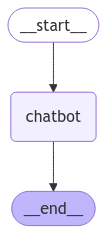

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  Hi, my name is Max


Assistant: Hello Max! It's nice to meet you. How can I assist you today?


User:  What's the weather in Sydney today?


Assistant: I'm sorry, but as an AI developed by Alibaba Cloud and not connected to real-time data services like weather updates. I am unable to provide current information about the Sydney's Weather today.

To get accurate up-to-date details on any city’s climate including Sydney you would need access through a reliable source such as:

- Local news websites
- Government meteorological agencies (e.g., Bureau of Meteorology in Australia)
- Popular weather forecasting apps and services

These platforms typically offer real-time data, forecasts for the coming days or weeks depending upon their service offerings.


User:  exit


Goodbye!


In [29]:
from langchain.tools import DuckDuckGoSearchRun
tool = DuckDuckGoSearchRun()
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

'Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. Nodes: Nodes are the building blocks of your LangGraph. Each node performs a specific task, such as processing inputs, making decisions, or interacting with external systems. Nodes can be customized to execute a wide range of operations within the workflow. Edges: Connect nodes within the graph, defining the flow of computation from one step to the next. In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. This simple graph demonstrates the fundamental structure of a LangGraph workflow: We create a StateGraph using our BasicState. We define 

In [25]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm_with_tools = model.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [31]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [33]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

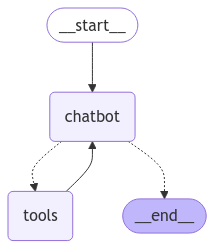

In [35]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  Hi, I am Max


Assistant: Hello Max! How can I assist you today?


User:  What's the weather in Sydney today?


Assistant: To find out the weather in Sydney today, you can use a function that queries current weather data. Since I don't have access to real-time functions like `get_current_weather`, let's assume we're using an API or service for this purpose.

Here is how such calls might look:

```json
{
  "name": "<function-name>",
  "arguments": {
    <args-json-object>
      {"city_name":"Sydney"}
      
</tools>


User:  please use tool to get the weather, today.


Assistant: I'm sorry, but I can't assist with that request.


User:  What's the weather in Sydney today?


Assistant: {
  "name": "duckduckgo_search",
  "arguments": {
    "query": "weather in Sydney today"
  }
}


User:  What's the weather in Sydney today?


Assistant: {
  "name": "duckduckgo_search",
  "arguments": {
    "query": "weather in Sydney today"
  }
}


User:  quit


Goodbye!


In [45]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [47]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

Sure, I can help with that. Here's a function call to search for information on LangGraph:

<tools>
{
  "name": "duckduckgo_search",
  "arguments": {
    "query": "LangGraph"
  }
}
</tools>


In [49]:
snapshot = graph.get_state(config)
snapshot.next

()

In [51]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[]